In [1]:
import QAData
from os import listdir
from os.path import isfile, join
import PassageRetrieval as pr
from json2html import *
import matplotlib
#matplotlib.use('Agg')
import pylab as plt
import nlp_utils
import time
import os
import json
import logging
from json_utils import JSONConnector
from QAData import DataSetFactory
import models
from passrtv_models import PassageRetrievalModel
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
from keras.layers import Convolution1D, Convolution2D
from keras.layers import Input, Embedding, merge, Flatten, SimpleRNN
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, Activation, Input, Dense, merge, Dropout, LSTM
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution1D, Convolution2D, GlobalMaxPooling2D, Activation, Input, Dense, merge, Dropout
from keras.layers import Flatten, SimpleRNN
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import Callback
from itertools import groupby
import sys
import pickle
import nlp_utils
import numpy as np
import threading
import models as models
from models import threadsafe_generator
from scipy import spatial
import nltk
from random import shuffle
import random

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


In [2]:
params = {
  "expriment_id" : "keras_convnet_$runid",
  "dataset_partitions" : ["train","validate","test"],
  "dataset": "TrecDataSet",
  "ground_truth_file": "/home/aerossom/passage-retrieval/experiments/gold-jakana-test.rank",
  "model" : "KerasConvNetModel_8",
  "modeldes" : "Convolutional NN with 1d input tensor cosine sim input matrix element wise multiplied by salience matrix",
  "out_folder": "/home/aerossom/passage-retrieval/experiments/",
  "working_folder": "/home/aerossom/passage-retrieval/experiments/working_files/",
  "trec_eval_path" : "/home/aerossom/trec_eval.9.0/trec_eval",
  "out_rank_file" : "keras_convnet_matrixsim_$runid.rank",
  "word2vect_path" : "/home/aerossom/datasets/word2vect/GoogleNews-vectors-negative300.bin",
  "preprocess_steps" : [],
  "method_params" : {
                      "optimizer": "rmsprop",
                      "loss":"mean_squared_error",
                      "monitor": "val_loss",
                      "verbose" : 1,
                      "positive_rate": 0.5,
            		      "epochs": 500,
            		      "batch_size": 256,
            		      "validation_size" : 64,
            		      "max_words" : 40,
            		      "patience": 50,
                      "convolution_2d" : {
                        "nb_filter": 64,
                        "nb_row": 3,
                        "nb_col": 3,
                        "subsample": 1,
                        "border_mode" : "valid",
                        "activation" : "relu"
                      },
                      "activation_2nd_Layer" : "relu",
                      "dense_4th_Layer" : 30,
                      "dropout" : 0.1,
                      "dense_6th_layer" : 1,
                      "end_layer_activation" : "sigmoid"
		    }
}

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
w2v_path = '/home/aerossom/datasets/word2vect/GoogleNews-vectors-negative300.bin'
w2v_util = nlp_utils.Word2vectUtils(w2v_path)

In [5]:
ds = DataSetFactory.loadDataSet('WikiQADataSet')
#ds = DataSetFactory.loadDataSet('TrecDataSet_TrainAll')
#ds = DataSetFactory.loadDataSet('WikiQADataSet')

qa_pair = {}
qa_pair['train'] = ds.build_qa_pairs(ds.questions['train'])
qa_pair['validate'] = ds.build_qa_pairs(ds.questions['validate'])
qa_pair['test'] = ds.build_qa_pairs(ds.questions['test'])

In [17]:
def avg_precision(y_true, y_pred):
    zipped = zip(y_true, y_pred)
    zipped.sort(key=lambda x:x[1],reverse=True)
    np_y_true, np_y_pred = zip(*zipped)
    k_list = [i for i in range(len(np_y_true)) if int(np_y_true[i])==1]
    score = 0.
    r = np.sum(np_y_true).astype(np.int64)
    for k in k_list:
        Yk = np.sum(np_y_true[:k+1])
        score += Yk/float(k+1)
    if r==0:
        return 0
    score/=(r)
    return score

"""
https://en.wikipedia.org/wiki/Mean_reciprocal_rank
"""
def reciprocal_rank(y_true, y_pred):
    zipped = zip(y_true, y_pred)
    zipped.sort(key=lambda x:x[1],reverse=True)
    count_r = 1.0
    rr_score = 0.0
    for y_t,y_p in zipped:
        if(y_t!=1):
            count_r += 1
        else:
            rr_score = 1.0/count_r
            break
    if count_r-1==len(y_true):
        rr_score = 0.0
    return rr_score

class MAPCallback(Callback):
    
    def __init__(self, validation_data, max_words, proc_funct, filepath, min_delta=0, patience=50, verbose=1, save_best_only=True, save_weights_only=True, period=1):
        super(MAPCallback, self).__init__()
        self.val_ds = validation_data
        self.max_words = max_words
        self.proc_fuction = proc_funct
        self.map_score = []
        self.mrr_score = []
        self.min_delta = min_delta
        #maximize the map
        self.monitor_op = np.greater
        self.patience = patience
        self.period = period
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.epochs_since_last_save = 0
        self.filepath = filepath
        self.min_delta *= -1
        self.stopped_epoch = 0
    
    def on_train_begin(self, logs=None):
        self.wait = 0  # Allow instances to be re-used
        self.best = np.Inf if self.monitor_op == np.less else -np.Inf

    def on_epoch_end(self, epoch, logs={}):
        current_map, current_mrr = self.calculate_map_mrr()
        self.save_model(epoch, logs, current_map)
        logging.info("MAP evaluation - epoch: {:d} - score: {:.6f}".format(epoch, current_map))
        logging.info("MRR evaluation - epoch: {:d} - score: {:.6f}".format(epoch, current_mrr))
        if current_map is None:
            warnings.warn('MAP Early stopping requires %s available!' %
                          (self.monitor), RuntimeWarning)

        if self.monitor_op(current_map - self.min_delta, self.best):
            self.best = current_map
            self.wait = 0
        else:
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
            self.wait += 1

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
        #    print('Epoch %05d: MAP early stopping' % (self.stopped_epoch))
            logging.info("MAP early stopping Epoch {:d} evaluation - MAP: {:.6f} ".format(self.stopped_epoch,self.best))
    
    def save_model(self, epoch, logs, cmap):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch, **logs)
            if self.save_best_only:
                current = cmap
                if current is None:
                    warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (' MAP '), RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print('Epoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch, ' MAP ', self.best,
                                     current, filepath))
                        self.best = current
                        if self.save_weights_only:
                            self.model.save_weights(filepath, overwrite=True)
                        else:
                            self.model.save(filepath, overwrite=True)
                    else:
                        if self.verbose > 0:
                            print('Epoch %05d: %s did not improve' %
                                  (epoch, ' MAP '))
            else:
                if self.verbose > 0:
                    print('Epoch %05d: saving model to %s' % (epoch, filepath))
                if self.save_weights_only:
                    self.model.save_weights(filepath, overwrite=True)
                else:
                    self.model.save(filepath, overwrite=True)

    def calculate_map_mrr(self):
        y_true = []
        y_pred = []
        avg_p = []
        rr_list = []
        num_groups = 0
        for key, group in groupby(self.val_ds, lambda x: x.qi):
            samples = []
            is_any_true = False
            for q_g in group:
                samples.append(q_g)
                if q_g.l == 1:
                    is_any_true = True
            #Just take the 1/3 of the dataset randomly
            if random.uniform(0, 10) > 8:
                is_any_true = False
            if is_any_true:
                x, y_true = self.proc_fuction(samples,max_terms=self.max_words)
                y_pred = self.model.predict_proba(x, verbose=0)
                avg_p_score = avg_precision(y_true, y_pred)
                avg_p.append( avg_p_score )
                rr_score = reciprocal_rank(y_true, y_pred)
                rr_list.append( rr_score )
                #print y_true
                #print y_pred
                #print 'avg_prec = ', avg_p_score, ', rr = ', rr_score
                num_groups += 1
        cmap_score = sum(avg_p)/num_groups
        cmrr_score = sum(rr_list)/num_groups
        self.map_score.append(cmap_score)
        self.mrr_score.append(cmrr_score)
        #print 'map = ', cmap_score, ', mrr = ', cmrr_score
        return cmap_score, cmrr_score

In [86]:
"""
Convolutional NN with 1d input tensor cosine sim input matrix element wise multiplied by salience matrix
"""
class KerasConvNetModel_8(models.PassageRetrievalModel):

    def __init__(self,init_params):
        super(KerasConvNetModel_8, self).__init__('KerasConvNetModel_8', init_params['runid'])
        self.w2vutil = init_params['w2v']
        self.w2v = self.w2vutil.getWord2VectModel()
        self.params = init_params['params']
        self.max_words = self.params['method_params']['max_words']
        self.positive_rate = self.params['method_params']['positive_rate']
        self.prep_step = [ str(step) for step in init_params['params']['preprocess_steps'] ]

    

    def getSalienceScore(self, qv, av, maxterms=40):
        score = 0
        imp_postag = set(['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'NN', 'NNS', 'NNP', 'NNPS', 'JJ'])
        #imp_postag = set(['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP', 'WRB', 'NN', 'NNS', 'NNP', 'NNPS', 'MD'])
        #imp_postag = set(['WRB','VB', 'VBD', 'VBG', 'VBN', 'VBP','VBZ', 'WDT', 'WP', 'WRB', 'NN', 'NNS', 'NNP', 'NNPS', 'MD'])
        pq = nltk.pos_tag(qv)
        pa = nltk.pos_tag(av)
        out_m = np.zeros( (maxterms, maxterms) )
        if len(pq)>maxterms:
            pq = pq[0:maxterms]
        if len(pa)>maxterms:
            pa = pa[0:maxterms]
        wq_m = np.zeros((maxterms,maxterms))
        wa_m = np.zeros((maxterms,maxterms))

        pq_l = [len(set([qt[1]]).intersection(imp_postag))+1 for qt in pq]
        pa_l = [len(set([at[1]]).intersection(imp_postag))+1 for at in pa]

        wq_m[0:len(pa_l) , 0:len(pq_l)]=pq_l
        wa_m[0:len(pq_l) , 0:len(pa_l)]=pa_l

        out_m = (wq_m.T + wa_m)/4
        return out_m[0:maxterms,0:maxterms]

    def buildCosineSimMatrix(self, questions_answer_pairs, max_terms=40):
        #Construct Question Answer Matrix Pairs
        x = []
        y = []
        for pair in questions_answer_pairs:
            #Question Processing
            q_list = nlp_utils.data_preprocess(pair.q,self.prep_step)
            q_vect = self.w2vutil.transform2Word2Vect(q_list)
            #Answer processing
            a_list = nlp_utils.data_preprocess(pair.a,self.prep_step)
            a_vect = self.w2vutil.transform2Word2Vect(a_list)
            #Get salience score
            #sal_matrix = self.getSalienceScore(q_list,a_list,max_terms)
            #Get cosine distance
            #distance = np.absolute( spatial.distance.cdist(q_vect[0:max_terms], a_vect[0:max_terms], 'cosine') )
            ''' with that param the MAP and Loss are  highly correlated
                and the improvement in MAP is very fast, but in test the results are almost equal
                cos_matrix = 1 - (1/(1+np.exp(-distance*3)))
                it changes a bit with
                cos_matrix = 1 - (1/(1+np.exp(-distance*2)))

            distance = spatial.distance.cdist(q_vect[0:max_terms], a_vect[0:max_terms],
              lambda u, v: (np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)))
                    if (np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))) >= 0
                    else -1.0*(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))) )
                    '''
            distance = spatial.distance.cdist(q_vect[0:max_terms], a_vect[0:max_terms], 'cosine')
            #cos_matrix = 1 - distance
            cos_matrix = 1 - distance/2
            shape_cos_matrix = cos_matrix.shape
            cos_matrix = np.pad(cos_matrix, ((0,max_terms-shape_cos_matrix[0]),(0,max_terms-shape_cos_matrix[1])), mode='constant')
            if np.isnan(cos_matrix).any():
                print 'ERROR IS NAN: ',pair
            #x.append( np.multiply(cos_matrix,sal_matrix).flatten() )
            x.append( cos_matrix.flatten() )
            y.append( pair.l )
        #print 'x shape: ', np.array(x).shape
        return np.array(x), np.array(y)

    def load_model(self):
        self.model = Sequential()
        mp = self.params['method_params']
        self.model.add(Dense(128, input_dim=1600, activation='relu'))
        self.model.add(Dense(32))
        self.model.add(Dropout(0.1))
        #self.model.add(Dense(mp['dense_6th_layer']))
        self.model.add(Dense(1, activation='sigmoid'))
        return self.model
    
    @threadsafe_generator
    def generateXYBatches(self, samples_xy, num_samples, positive_rate=0.5):
        num_pos_samples = int(num_samples*(positive_rate))
        positiveSamples = [ q for q in samples_xy if q[1]==1 ]
        negativeSamples = [ q for q in samples_xy if q[1]==0 ]
        print 'samples = ',num_samples, ', len+:', len(positiveSamples), ', len-:',len(negativeSamples)
        samples_xy = random.sample(positiveSamples, num_pos_samples)+random.sample(negativeSamples, num_samples-num_pos_samples)
        shuffle(samples_xy)
        while 1:
            x,y = zip(*samples_xy)
            #'x_shape: ',np.array(x).shape
            #x, y = self.buildCosineSimMatrix(samples,max_terms=self.max_words)
            yield ( np.array(x), np.array(y) )

    def train(self, ds, qa_pair):
        self.model = self.load_model()
        self.best_params=self.params['working_folder']+self.params['expriment_id'].replace('$runid',self.runid)+"_best.hdf5"
        #if want to load the best weights in other training
        #self.model.load_weights(self.best_params)
        #MAP CallBack
        map_callback = MAPCallback(qa_pair['validate'], self.max_words, self.buildCosineSimMatrix, self.best_params)
        # checkpoints
        #output the model weights each time an improvement is observed during training
        #checkpoint = ModelCheckpoint(self.best_params, monitor=self.params['method_params']['monitor'], verbose=self.params['method_params']['verbose'], save_best_only=True, mode='auto')
        #stops if the model is not learning at any point
        #earlyStopping= EarlyStopping(monitor=self.params['method_params']['monitor'], patience=self.params['method_params']['patience'], verbose=self.params['method_params']['verbose'], mode='auto')
        train_qxa, train_l = k_model.buildCosineSimMatrix(qa_pair['train'][0:100], max_terms=40)
        val_qxa, val_l   = k_model.buildCosineSimMatrix(qa_pair['validate'][0:100], max_terms=40)
        
        epochs_number = self.params['method_params']['epochs']
        batch_size = self.params['method_params']['batch_size']
        validation_size = self.params['method_params']['validation_size']

        self.model.compile(loss='mean_squared_error',
                      optimizer='rmsprop',
                      metrics=['accuracy'])

        history = self.model.fit_generator(
                    self.generateXYBatches( zip(train_qxa,train_l ), 2, positive_rate=self.positive_rate),
                    samples_per_epoch=batch_size,
                    validation_data=self.generateXYBatches( zip(val_qxa,val_l), 2, positive_rate=self.positive_rate),
                    nb_val_samples=2,
                    nb_epoch=epochs_number,
                    callbacks=[map_callback]
                    #callbacks=[checkpoint, earlyStopping, map_callback]
                    )
        
        #Add MAP and MRR to history
        history.history['map'] = map_callback.map_score
        history.history['mrr'] = map_callback.mrr_score
        #Save history object in pickel
        self.save_history( self.best_params.replace('_best.hdf5','_history.pkl'), history )
        return history
    
    def save_history(self,out_file, history):
        with open(out_file, 'wb') as output:
            pickle.dump(history.history, output, pickle.HIGHEST_PROTOCOL)
        """
        To Open 
            with open('in_file.pkl', 'rb') as input:
                history = pickle.load(input)
        """

    def test(self, ds, qa_pairs):
        #reload best weights
        self.model.load_weights(self.best_params)
        #Construct Test dataset
        test_qxa, test_l = self.buildCosineSimMatrix(qa_pairs, max_terms=self.max_words)
        predictions = self.model.predict(np.array(test_qxa))
        return predictions

In [87]:
model_params = {"w2v": w2v_util, "runid":'test_run',  "params":params }
k_model = KerasConvNetModel_8(model_params)

In [88]:
k_model.load_model().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_109 (Dense)                (None, 128)           204928      dense_input_40[0][0]             
____________________________________________________________________________________________________
dense_110 (Dense)                (None, 32)            4128        dense_109[0][0]                  
____________________________________________________________________________________________________
dropout_38 (Dropout)             (None, 32)            0           dense_110[0][0]                  
____________________________________________________________________________________________________
dense_111 (Dense)                (None, 1)             33          dropout_38[0][0]                 
Total params: 209089
______________________________________________________________________

In [90]:
history = k_model.train(ds, qa_pair)

samples = Epoch 1/500 
2 , len+: 5 , len-: 95
248/256 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9919samples =  2 , len+: 5 , len-: 95


INFO:root:MAP evaluation - epoch: 0 - score: 0.334875
INFO:root:MRR evaluation - epoch: 0 - score: 0.338902


Epoch 00000:  MAP  improved from -inf to 0.33487, saving model to /home/aerossom/passage-retrieval/experiments/working_files/keras_convnet_test_run_best.hdf5
256/256 [==============================] - 1s - loss: 0.0054 - acc: 0.9922 - val_loss: 0.2302 - val_acc: 0.5000
Epoch 2/500
252/256 [============================>.] - ETA: 0s - loss: 1.7314e-07 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 1 - score: 0.337447
INFO:root:MRR evaluation - epoch: 1 - score: 0.340792


Epoch 00001:  MAP  improved from 0.33487 to 0.33745, saving model to /home/aerossom/passage-retrieval/experiments/working_files/keras_convnet_test_run_best.hdf5
256/256 [==============================] - 1s - loss: 1.7044e-07 - acc: 1.0000 - val_loss: 0.3611 - val_acc: 0.5000
Epoch 3/500
254/256 [============================>.] - ETA: 0s - loss: 1.0303e-09 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 2 - score: 0.338953
INFO:root:MRR evaluation - epoch: 2 - score: 0.340283


Epoch 00002:  MAP  improved from 0.33745 to 0.33895, saving model to /home/aerossom/passage-retrieval/experiments/working_files/keras_convnet_test_run_best.hdf5
256/256 [==============================] - 1s - loss: 1.0241e-09 - acc: 1.0000 - val_loss: 0.3315 - val_acc: 0.5000
Epoch 4/500
250/256 [============================>.] - ETA: 0s - loss: 1.2615e-10 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 3 - score: 0.357427
INFO:root:MRR evaluation - epoch: 3 - score: 0.361283


Epoch 00003:  MAP  improved from 0.33895 to 0.35743, saving model to /home/aerossom/passage-retrieval/experiments/working_files/keras_convnet_test_run_best.hdf5
256/256 [==============================] - 1s - loss: 1.2324e-10 - acc: 1.0000 - val_loss: 0.3026 - val_acc: 0.5000
Epoch 5/500
250/256 [============================>.] - ETA: 0s - loss: 6.3599e-11 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 4 - score: 0.330691
INFO:root:MRR evaluation - epoch: 4 - score: 0.335541


Epoch 00004:  MAP  did not improve
256/256 [==============================] - 1s - loss: 6.2157e-11 - acc: 1.0000 - val_loss: 0.2813 - val_acc: 0.5000
Epoch 6/500
248/256 [============================>.] - ETA: 0s - loss: 2.4215e-11 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 5 - score: 0.364728
INFO:root:MRR evaluation - epoch: 5 - score: 0.369627


Epoch 00005:  MAP  improved from 0.35743 to 0.36473, saving model to /home/aerossom/passage-retrieval/experiments/working_files/keras_convnet_test_run_best.hdf5
256/256 [==============================] - 1s - loss: 2.3566e-11 - acc: 1.0000 - val_loss: 0.2752 - val_acc: 0.5000
Epoch 7/500
250/256 [============================>.] - ETA: 0s - loss: 1.3174e-11 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 6 - score: 0.351340
INFO:root:MRR evaluation - epoch: 6 - score: 0.352214


Epoch 00006:  MAP  did not improve
256/256 [==============================] - 1s - loss: 1.2907e-11 - acc: 1.0000 - val_loss: 0.2756 - val_acc: 0.5000
Epoch 8/500
250/256 [============================>.] - ETA: 0s - loss: 1.2458e-11 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 7 - score: 0.347089
INFO:root:MRR evaluation - epoch: 7 - score: 0.348964


Epoch 00007:  MAP  did not improve
256/256 [==============================] - 1s - loss: 1.2386e-11 - acc: 1.0000 - val_loss: 0.2744 - val_acc: 0.5000
Epoch 9/500
252/256 [============================>.] - ETA: 0s - loss: 5.3280e-11 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 8 - score: 0.344844
INFO:root:MRR evaluation - epoch: 8 - score: 0.349951


Epoch 00008:  MAP  did not improve
256/256 [==============================] - 1s - loss: 5.2459e-11 - acc: 1.0000 - val_loss: 0.2567 - val_acc: 0.5000
Epoch 10/500
254/256 [============================>.] - ETA: 0s - loss: 1.1527e-11 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 9 - score: 0.328503
INFO:root:MRR evaluation - epoch: 9 - score: 0.331665


Epoch 00009:  MAP  did not improve
256/256 [==============================] - 1s - loss: 1.1553e-11 - acc: 1.0000 - val_loss: 0.2602 - val_acc: 0.5000
Epoch 11/500
254/256 [============================>.] - ETA: 0s - loss: 1.0365e-10 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 10 - score: 0.340754
INFO:root:MRR evaluation - epoch: 10 - score: 0.345196


Epoch 00010:  MAP  did not improve
256/256 [==============================] - 1s - loss: 1.0285e-10 - acc: 1.0000 - val_loss: 0.3286 - val_acc: 0.5000
Epoch 12/500
252/256 [============================>.] - ETA: 0s - loss: 1.3778e-11 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 11 - score: 0.333223
INFO:root:MRR evaluation - epoch: 11 - score: 0.338536


Epoch 00011:  MAP  did not improve
256/256 [==============================] - 1s - loss: 1.3578e-11 - acc: 1.0000 - val_loss: 0.3253 - val_acc: 0.5000
Epoch 13/500
252/256 [============================>.] - ETA: 0s - loss: 6.3360e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 12 - score: 0.366882
INFO:root:MRR evaluation - epoch: 12 - score: 0.371283


Epoch 00012:  MAP  improved from 0.36473 to 0.36688, saving model to /home/aerossom/passage-retrieval/experiments/working_files/keras_convnet_test_run_best.hdf5
256/256 [==============================] - 1s - loss: 6.2515e-12 - acc: 1.0000 - val_loss: 0.3226 - val_acc: 0.5000
Epoch 14/500
250/256 [============================>.] - ETA: 0s - loss: 1.2470e-11 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 13 - score: 0.354638
INFO:root:MRR evaluation - epoch: 13 - score: 0.359691


Epoch 00013:  MAP  did not improve
256/256 [==============================] - 1s - loss: 1.2233e-11 - acc: 1.0000 - val_loss: 0.3185 - val_acc: 0.5000
Epoch 15/500
252/256 [============================>.] - ETA: 0s - loss: 2.9421e-11 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 14 - score: 0.351692
INFO:root:MRR evaluation - epoch: 14 - score: 0.356272


Epoch 00014:  MAP  did not improve
256/256 [==============================] - 1s - loss: 2.8968e-11 - acc: 1.0000 - val_loss: 0.3051 - val_acc: 0.5000
Epoch 16/500
248/256 [============================>.] - ETA: 0s - loss: 8.2248e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 15 - score: 0.347412
INFO:root:MRR evaluation - epoch: 15 - score: 0.351791


Epoch 00015:  MAP  did not improve
256/256 [==============================] - 1s - loss: 8.0353e-12 - acc: 1.0000 - val_loss: 0.3031 - val_acc: 0.5000
Epoch 17/500
252/256 [============================>.] - ETA: 0s - loss: 3.9537e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 16 - score: 0.355044
INFO:root:MRR evaluation - epoch: 16 - score: 0.360249


Epoch 00016:  MAP  did not improve
256/256 [==============================] - 1s - loss: 3.9037e-12 - acc: 1.0000 - val_loss: 0.3025 - val_acc: 0.5000
Epoch 18/500
250/256 [============================>.] - ETA: 0s - loss: 5.7653e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 17 - score: 0.333769
INFO:root:MRR evaluation - epoch: 17 - score: 0.336406


Epoch 00017:  MAP  did not improve
256/256 [==============================] - 1s - loss: 5.6625e-12 - acc: 1.0000 - val_loss: 0.3026 - val_acc: 0.5000
Epoch 19/500
250/256 [============================>.] - ETA: 0s - loss: 4.9641e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 18 - score: 0.336314
INFO:root:MRR evaluation - epoch: 18 - score: 0.340543


Epoch 00018:  MAP  did not improve
256/256 [==============================] - 1s - loss: 5.6327e-12 - acc: 1.0000 - val_loss: 0.3010 - val_acc: 0.5000
Epoch 20/500
250/256 [============================>.] - ETA: 0s - loss: 3.2598e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 19 - score: 0.343027
INFO:root:MRR evaluation - epoch: 19 - score: 0.346639


Epoch 00019:  MAP  did not improve
256/256 [==============================] - 1s - loss: 3.1983e-12 - acc: 1.0000 - val_loss: 0.3003 - val_acc: 0.5000
Epoch 21/500
252/256 [============================>.] - ETA: 0s - loss: 4.2551e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 20 - score: 0.333613
INFO:root:MRR evaluation - epoch: 20 - score: 0.334553


Epoch 00020:  MAP  did not improve
256/256 [==============================] - 1s - loss: 4.1905e-12 - acc: 1.0000 - val_loss: 0.2985 - val_acc: 0.5000
Epoch 22/500
254/256 [============================>.] - ETA: 0s - loss: 7.1024e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 21 - score: 0.348365
INFO:root:MRR evaluation - epoch: 21 - score: 0.350874


Epoch 00021:  MAP  did not improve
256/256 [==============================] - 1s - loss: 7.0478e-12 - acc: 1.0000 - val_loss: 0.2955 - val_acc: 0.5000
Epoch 23/500
254/256 [============================>.] - ETA: 0s - loss: 9.0664e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 22 - score: 0.339380
INFO:root:MRR evaluation - epoch: 22 - score: 0.344178


Epoch 00022:  MAP  did not improve
256/256 [==============================] - 1s - loss: 9.0276e-12 - acc: 1.0000 - val_loss: 0.2946 - val_acc: 0.5000
Epoch 24/500
252/256 [============================>.] - ETA: 0s - loss: 2.7663e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 23 - score: 0.355409
INFO:root:MRR evaluation - epoch: 23 - score: 0.359900


Epoch 00023:  MAP  did not improve
256/256 [==============================] - 1s - loss: 2.7276e-12 - acc: 1.0000 - val_loss: 0.2935 - val_acc: 0.5000
Epoch 25/500
248/256 [============================>.] - ETA: 0s - loss: 3.4715e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 24 - score: 0.338149
INFO:root:MRR evaluation - epoch: 24 - score: 0.340045


Epoch 00024:  MAP  did not improve
256/256 [==============================] - 1s - loss: 3.3751e-12 - acc: 1.0000 - val_loss: 0.2922 - val_acc: 0.5000
Epoch 26/500
254/256 [============================>.] - ETA: 0s - loss: 5.8606e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 25 - score: 0.357439
INFO:root:MRR evaluation - epoch: 25 - score: 0.356947


Epoch 00025:  MAP  did not improve
256/256 [==============================] - 1s - loss: 5.8151e-12 - acc: 1.0000 - val_loss: 0.2907 - val_acc: 0.5000
Epoch 27/500
254/256 [============================>.] - ETA: 0s - loss: 3.6551e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 26 - score: 0.333441
INFO:root:MRR evaluation - epoch: 26 - score: 0.338125


Epoch 00026:  MAP  did not improve
256/256 [==============================] - 1s - loss: 3.6297e-12 - acc: 1.0000 - val_loss: 0.2911 - val_acc: 0.5000
Epoch 28/500
250/256 [============================>.] - ETA: 0s - loss: 2.3769e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 27 - score: 0.358543
INFO:root:MRR evaluation - epoch: 27 - score: 0.364122


Epoch 00027:  MAP  did not improve
256/256 [==============================] - 1s - loss: 2.3394e-12 - acc: 1.0000 - val_loss: 0.2915 - val_acc: 0.5000
Epoch 29/500
250/256 [============================>.] - ETA: 0s - loss: 2.8979e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 28 - score: 0.339932
INFO:root:MRR evaluation - epoch: 28 - score: 0.344049


Epoch 00028:  MAP  did not improve
256/256 [==============================] - 1s - loss: 2.9159e-12 - acc: 1.0000 - val_loss: 0.2916 - val_acc: 0.5000
Epoch 30/500
250/256 [============================>.] - ETA: 0s - loss: 6.4048e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 29 - score: 0.355359
INFO:root:MRR evaluation - epoch: 29 - score: 0.359366


Epoch 00029:  MAP  did not improve
256/256 [==============================] - 1s - loss: 6.2604e-12 - acc: 1.0000 - val_loss: 0.2892 - val_acc: 0.5000
Epoch 31/500
254/256 [============================>.] - ETA: 0s - loss: 2.1240e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 30 - score: 0.342518
INFO:root:MRR evaluation - epoch: 30 - score: 0.347410


Epoch 00030:  MAP  did not improve
256/256 [==============================] - 1s - loss: 2.1235e-12 - acc: 1.0000 - val_loss: 0.2889 - val_acc: 0.5000
Epoch 32/500
250/256 [============================>.] - ETA: 0s - loss: 4.3632e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 31 - score: 0.341803
INFO:root:MRR evaluation - epoch: 31 - score: 0.339793


Epoch 00031:  MAP  did not improve
256/256 [==============================] - 1s - loss: 4.2956e-12 - acc: 1.0000 - val_loss: 0.2897 - val_acc: 0.5000
Epoch 33/500
254/256 [============================>.] - ETA: 0s - loss: 3.3023e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 32 - score: 0.352678
INFO:root:MRR evaluation - epoch: 32 - score: 0.356788


Epoch 00032:  MAP  did not improve
256/256 [==============================] - 1s - loss: 3.2779e-12 - acc: 1.0000 - val_loss: 0.2894 - val_acc: 0.5000
Epoch 34/500
250/256 [============================>.] - ETA: 0s - loss: 2.0418e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 33 - score: 0.333518
INFO:root:MRR evaluation - epoch: 33 - score: 0.338090


Epoch 00033:  MAP  did not improve
256/256 [==============================] - 1s - loss: 2.5583e-12 - acc: 1.0000 - val_loss: 0.2885 - val_acc: 0.5000
Epoch 35/500
250/256 [============================>.] - ETA: 0s - loss: 1.3215e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 34 - score: 0.348777
INFO:root:MRR evaluation - epoch: 34 - score: 0.355063


Epoch 00034:  MAP  did not improve
256/256 [==============================] - 1s - loss: 1.4742e-12 - acc: 1.0000 - val_loss: 0.2882 - val_acc: 0.5000
Epoch 36/500
254/256 [============================>.] - ETA: 0s - loss: 2.0849e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 35 - score: 0.349004
INFO:root:MRR evaluation - epoch: 35 - score: 0.353764


Epoch 00035:  MAP  did not improve
256/256 [==============================] - 1s - loss: 2.0706e-12 - acc: 1.0000 - val_loss: 0.2879 - val_acc: 0.5000
Epoch 37/500
254/256 [============================>.] - ETA: 0s - loss: 5.2672e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 36 - score: 0.332957
INFO:root:MRR evaluation - epoch: 36 - score: 0.335315


Epoch 00036:  MAP  did not improve
256/256 [==============================] - 1s - loss: 5.3539e-12 - acc: 1.0000 - val_loss: 0.2872 - val_acc: 0.5000
Epoch 38/500
248/256 [============================>.] - ETA: 0s - loss: 2.2150e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 37 - score: 0.330366
INFO:root:MRR evaluation - epoch: 37 - score: 0.330547


Epoch 00037:  MAP  did not improve
256/256 [==============================] - 1s - loss: 2.1565e-12 - acc: 1.0000 - val_loss: 0.2862 - val_acc: 0.5000
Epoch 39/500
254/256 [============================>.] - ETA: 0s - loss: 1.4211e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 38 - score: 0.336472
INFO:root:MRR evaluation - epoch: 38 - score: 0.339545


Epoch 00038:  MAP  did not improve
256/256 [==============================] - 1s - loss: 1.4168e-12 - acc: 1.0000 - val_loss: 0.2861 - val_acc: 0.5000
Epoch 40/500
254/256 [============================>.] - ETA: 0s - loss: 1.1949e-11 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 39 - score: 0.362826
INFO:root:MRR evaluation - epoch: 39 - score: 0.366357


Epoch 00039:  MAP  did not improve
256/256 [==============================] - 1s - loss: 1.1890e-11 - acc: 1.0000 - val_loss: 0.2806 - val_acc: 0.5000
Epoch 41/500
250/256 [============================>.] - ETA: 0s - loss: 1.3115e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 40 - score: 0.326747
INFO:root:MRR evaluation - epoch: 40 - score: 0.328366


Epoch 00040:  MAP  did not improve
256/256 [==============================] - 1s - loss: 1.2845e-12 - acc: 1.0000 - val_loss: 0.2805 - val_acc: 0.5000
Epoch 42/500
254/256 [============================>.] - ETA: 0s - loss: 1.6742e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 41 - score: 0.349565
INFO:root:MRR evaluation - epoch: 41 - score: 0.353615


Epoch 00041:  MAP  did not improve
256/256 [==============================] - 1s - loss: 1.6621e-12 - acc: 1.0000 - val_loss: 0.2799 - val_acc: 0.5000
Epoch 43/500
248/256 [============================>.] - ETA: 0s - loss: 1.3205e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 42 - score: 0.330941
INFO:root:MRR evaluation - epoch: 42 - score: 0.333070


Epoch 00042:  MAP  did not improve
256/256 [==============================] - 1s - loss: 1.2889e-12 - acc: 1.0000 - val_loss: 0.2798 - val_acc: 0.5000
Epoch 44/500
252/256 [============================>.] - ETA: 0s - loss: 6.4175e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 43 - score: 0.357058
INFO:root:MRR evaluation - epoch: 43 - score: 0.361811


Epoch 00043:  MAP  did not improve
256/256 [==============================] - 1s - loss: 6.3254e-12 - acc: 1.0000 - val_loss: 0.2776 - val_acc: 0.5000
Epoch 45/500
252/256 [============================>.] - ETA: 0s - loss: 1.7791e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 44 - score: 0.341424
INFO:root:MRR evaluation - epoch: 44 - score: 0.343790


Epoch 00044:  MAP  did not improve
256/256 [==============================] - 1s - loss: 1.7757e-12 - acc: 1.0000 - val_loss: 0.2771 - val_acc: 0.5000
Epoch 46/500
250/256 [============================>.] - ETA: 0s - loss: 1.9988e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 45 - score: 0.333368
INFO:root:MRR evaluation - epoch: 45 - score: 0.335917


Epoch 00045:  MAP  did not improve
256/256 [==============================] - 1s - loss: 1.9545e-12 - acc: 1.0000 - val_loss: 0.2767 - val_acc: 0.5000
Epoch 47/500
250/256 [============================>.] - ETA: 0s - loss: 3.8315e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 46 - score: 0.331484
INFO:root:MRR evaluation - epoch: 46 - score: 0.335792


Epoch 00046:  MAP  did not improve
256/256 [==============================] - 1s - loss: 3.7421e-12 - acc: 1.0000 - val_loss: 0.2770 - val_acc: 0.5000
Epoch 48/500
252/256 [============================>.] - ETA: 0s - loss: 1.8013e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 47 - score: 0.334918
INFO:root:MRR evaluation - epoch: 47 - score: 0.338127


Epoch 00047:  MAP  did not improve
256/256 [==============================] - 1s - loss: 1.7741e-12 - acc: 1.0000 - val_loss: 0.2763 - val_acc: 0.5000
Epoch 49/500
254/256 [============================>.] - ETA: 0s - loss: 1.5589e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 48 - score: 0.355613
INFO:root:MRR evaluation - epoch: 48 - score: 0.358016


Epoch 00048:  MAP  did not improve
256/256 [==============================] - 1s - loss: 1.5534e-12 - acc: 1.0000 - val_loss: 0.2766 - val_acc: 0.5000
Epoch 50/500
250/256 [============================>.] - ETA: 0s - loss: 3.1987e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 49 - score: 0.344457
INFO:root:MRR evaluation - epoch: 49 - score: 0.348456


Epoch 00049:  MAP  did not improve
256/256 [==============================] - 1s - loss: 3.1336e-12 - acc: 1.0000 - val_loss: 0.2762 - val_acc: 0.5000
Epoch 51/500
250/256 [============================>.] - ETA: 0s - loss: 1.4338e-12 - acc: 1.0000

INFO:root:MAP evaluation - epoch: 50 - score: 0.360346
INFO:root:MRR evaluation - epoch: 50 - score: 0.364917


Epoch 00050:  MAP  did not improve
256/256 [==============================] - 1s - loss: 1.4075e-12 - acc: 1.0000 - val_loss: 0.2762 - val_acc: 0.5000

INFO:root:MAP early stopping Epoch 50 evaluation - MAP: 0.366882 


In [93]:
import keras
keras.__version__
from keras.layers import MaxPooling2D, Convolution2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Activation, Input, Dense, merge, Dropout, LSTM

In [120]:
in_file = '/home/aerossom/passage-retrieval/experiments/working_files/keras_convnet_test_run_history.pkl'

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 17.2 µs


In [333]:
qa_pair['train'][0].a

'the iron lady ; a biography of margaret thatcher by hugo young -lrb- farrar , straus & giroux -rrb-'

In [207]:
cosine_matrix = k_model.buildCosineSimMatrix(qa_pair['train'][0:1000],max_terms=17)

In [208]:
print max(np.array(cosine_matrix[0]).flatten())

0.999990119566


In [412]:
cosine_matrix[0][0][0].shape

(17, 17)

In [423]:
pq = nltk.pos_tag(xq)
pa = nltk.pos_tag(xa)

In [424]:
print pq,'\n\n', pa

[('who', 'WP'), ('is', 'VBZ'), ('the', 'DT'), ('author', 'NN'), ('of', 'IN'), ('the', 'DT'), ('book', 'NN'), ('the', 'DT'), ('iron', 'NN'), ('lady', 'NN'), ('a', 'DT'), ('biography', 'NN'), ('of', 'IN'), ('margaret', 'NN'), ('thatcher', 'NN')] 

[('the', 'DT'), ('iron', 'NN'), ('lady', 'NN'), ('a', 'DT'), ('biography', 'NN'), ('of', 'IN'), ('margaret', 'NN'), ('thatcher', 'NN'), ('by', 'IN'), ('hugo', 'NN'), ('young', 'JJ'), ('lrb', 'NN'), ('farrar', 'NN'), ('straus', 'VBZ'), ('giroux', 'NN'), ('rrb', 'NN')]


In [ ]:
np.set_printoptions(precision=1)
np.set_printoptions(threshold='nan')
np.set_printoptions(suppress=True)
#print test_qxa[0]
print np.array_str(cosine_matrix[0][0][0], precision=2, suppress_small=True)

In [435]:
print str(spatial.distance.cosine(w2v_util.w2v_model['book'], w2v_util.w2v_model['biography']))

0.384415864944


In [19]:
with open(in_file, 'rb') as input:
    history = pickle.load(input)

In [240]:
#First predictions
k_model = KerasConvNetModel_8(model_params)
test_qxa, test_l = k_model.buildCosineSimMatrix(qa_pair['test'], max_terms=40)
#train_qxa, train_l = k_model.buildCosineSimMatrix(qa_pair['train'], max_terms=40)

In [221]:
max(test_qxa.flatten())

1.0000000000000004

In [82]:
test_qxa.shape

(1517, 1, 40, 40)

In [83]:
pair = zip(test_qxa, test_l )

In [84]:
np.array(zip(*pair)[0]).shape

(1517, 1, 40, 40)

In [85]:
print qa_pair['train'][0].q, qa_pair['train'][0].a

who is the author of the book , `` the iron lady : a biography of margaret thatcher '' ? the iron lady ; a biography of margaret thatcher by hugo young -lrb- farrar , straus & giroux -rrb-


In [ ]:
np.set_printoptions(precision=1)
np.set_printoptions(threshold='nan')
np.set_printoptions(suppress=True)
#print test_qxa[0]
print np.array_str(train_qxa[0], precision=1, suppress_small=True)

In [238]:
spatial.distance.cosine(w2v_util.w2v_model['glacier'], w2v_util.w2v_model['oil'])

0.87770495563745499

In [241]:
from keras import models
model = models.load_model('/home/aerossom/passage-retrieval/experiments/working_files/keras_convnet_1493417216_best.hdf5')

th


In [242]:
from nlp_utils import avg_precision
from nlp_utils import reciprocal_rank
#Make the first preditions
first_predictions = model.predict(np.array(test_qxa))
rank_file_1 = 'experiments/rankfile_0.rank'
idx_pred = 0
rank_text = ''
for key,group in groupby(qa_pair['test'], lambda x: x.qi):
    for i, qp in enumerate(group):
        rank_text += str(qp.qi) + ' 0 ' + str(qp.ai) + ' 0 ' + str(first_predictions[idx_pred][0]) + ' 0\n'
        idx_pred += 1
with open(rank_file_1, 'wb') as text_file:
    text_file.write(rank_text)

In [ ]:
#Trec
!/home/aerossom/trec_eval.9.0/trec_eval -c /home/aerossom/passage-retrieval/experiments/gold-jakana-test2.rank \
experiments/rankfile_0.rank

In [243]:
#WikiQA
!/home/aerossom/trec_eval.9.0/trec_eval -c /home/aerossom/datasets/WikiQACorpus/WikiQA-test-filtered.ref \
experiments/rankfile_0.rank

runid                 	all	0
num_q                 	all	237
num_ret               	all	2341
num_rel               	all	283
num_rel_ret           	all	283
map                   	all	0.6080
gm_map                	all	0.4780
Rprec                 	all	0.4409
bpref                 	all	0.4342
recip_rank            	all	0.6165
iprec_at_recall_0.00  	all	0.6215
iprec_at_recall_0.10  	all	0.6215
iprec_at_recall_0.20  	all	0.6215
iprec_at_recall_0.30  	all	0.6183
iprec_at_recall_0.40  	all	0.6183
iprec_at_recall_0.50  	all	0.6183
iprec_at_recall_0.60  	all	0.6038
iprec_at_recall_0.70  	all	0.6038
iprec_at_recall_0.80  	all	0.5997
iprec_at_recall_0.90  	all	0.5997
iprec_at_recall_1.00  	all	0.5997
P_5                   	all	0.1890
P_10                  	all	0.1118
P_15                  	all	0.0776
P_20                  	all	0.0593
P_30                  	all	0.0398
P_100                 	all	0.0119
P_200                 	all	0.0060
P_500                 	all	0.0024
P_1000                	all	0.0

In [244]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

In [283]:
from QAData import QAPair

first_map = []
second_map = []
final_1_predictions = []
final_2_predictions = []
ids_q = []
for key,group in groupby(qa_pair['test'], lambda x: x.qi):
    first_qapair = []
    for qp in group:
        first_qapair.append(qp)
    # Get first predictions without rerank
    first_qxa, first_l = k_model.buildCosineSimMatrix(first_qapair, max_terms=k_model.max_words)
    first_predictions = model.predict(np.array(first_qxa))
    first_map.append(avg_precision(first_l, first_predictions))
    final_1_predictions.extend(first_predictions)
    # Get second preditions taking into account the pseudo relevance feedback
    maxq = np.argmax(first_predictions)
    #print first_predictions
    #q_1 = ' '.join([word for word in first_qapair[maxq].q.split() if word not in (stopwords.words('english'))])
    if first_predictions[maxq] > 0.6:
        a_1 = ' '.join([word for word in first_qapair[maxq].a.split() if word not in (stopwords.words('english'))])
    else: 
        a_1 = ' '
    #a_1 = ' '.join([word for word in first_qapair[maxq].a.split()])
    q = ' '.join( [ word for word in qp.q.split() ] )
    second_qapair = [ QAPair(qp.qi, q+' '+a_1,qp.ai,qp.a,qp.l) for qp in first_qapair ]
    second_qxa, second_l = k_model.buildCosineSimMatrix(second_qapair, max_terms=k_model.max_words)
    second_predictions = model.predict(np.array(second_qxa))
    second_predictions[maxq] = 1.0
    second_map.append(avg_precision(second_l, second_predictions))
    final_2_predictions.extend(second_predictions)
    print first_qapair[0].qi, ' l=',sum(first_l), 'map_1: ', first_map[len(first_map)-1] ,' map_2: ', second_map[len(second_map)-1]
    #print first_map, second_map

1  l= 1 map_1:  1.0  map_2:  1.0
2  l= 0 map_1:  0  map_2:  0
3  l= 1 map_1:  0.333333333333  map_2:  0.333333333333
4  l= 1 map_1:  1.0  map_2:  1.0
5  l= 4 map_1:  0.172442323758  map_2:  0.218181818182
6  l= 0 map_1:  0  map_2:  0
7  l= 0 map_1:  0  map_2:  0
8  l= 0 map_1:  0  map_2:  0
9  l= 0 map_1:  0  map_2:  0
10  l= 1 map_1:  0.25  map_2:  0.166666666667
11  l= 1 map_1:  1.0  map_2:  1.0
12  l= 0 map_1:  0  map_2:  0
13  l= 0 map_1:  0  map_2:  0
14  l= 0 map_1:  0  map_2:  0
15  l= 0 map_1:  0  map_2:  0
16  l= 0 map_1:  0  map_2:  0
17  l= 0 map_1:  0  map_2:  0
18  l= 0 map_1:  0  map_2:  0
19  l= 0 map_1:  0  map_2:  0
20  l= 2 map_1:  0.642857142857  map_2:  0.642857142857
21  l= 1 map_1:  1.0  map_2:  1.0
22  l= 1 map_1:  0.333333333333  map_2:  0.333333333333
23  l= 0 map_1:  0  map_2:  0
24  l= 1 map_1:  0.5  map_2:  0.142857142857
25  l= 0 map_1:  0  map_2:  0
26  l= 0 map_1:  0  map_2:  0
27  l= 2 map_1:  0.208333333333  map_2:  0.375
28  l= 1 map_1:  0.5  map_2:  0

In [290]:
print sum(first_map)/len(first_map)

0.237475862606


In [291]:
print sum(second_map)/len(second_map)

0.232050718037


In [292]:
rank_file_1 = 'experiments/rankfile_1.rank'
idx_pred = 0
rank_text = ''
for key,group in groupby(qa_pair['test'], lambda x: x.qi):
    for i, qp in enumerate(group):
        rank_text += str(qp.qi) + ' 0 ' + str(qp.ai) + ' 0 ' + str(final_2_predictions[idx_pred][0]) + ' 0\n'
        idx_pred += 1
with open(rank_file_1, 'wb') as text_file:
    text_file.write(rank_text)

In [ ]:
!/home/aerossom/trec_eval.9.0/trec_eval -c /home/aerossom/passage-retrieval/experiments/gold-jakana-test2.rank experiments/rankfile_1.rank

In [293]:
!/home/aerossom/trec_eval.9.0/trec_eval -c /home/aerossom/datasets/WikiQACorpus/WikiQA-test-filtered.ref \
experiments/rankfile_1.rank

runid                 	all	0
num_q                 	all	237
num_ret               	all	2341
num_rel               	all	283
num_rel_ret           	all	283
map                   	all	0.5935
gm_map                	all	0.4521
Rprec                 	all	0.4385
bpref                 	all	0.4340
recip_rank            	all	0.6028
iprec_at_recall_0.00  	all	0.6081
iprec_at_recall_0.10  	all	0.6081
iprec_at_recall_0.20  	all	0.6081
iprec_at_recall_0.30  	all	0.6045
iprec_at_recall_0.40  	all	0.6045
iprec_at_recall_0.50  	all	0.6045
iprec_at_recall_0.60  	all	0.5892
iprec_at_recall_0.70  	all	0.5892
iprec_at_recall_0.80  	all	0.5844
iprec_at_recall_0.90  	all	0.5844
iprec_at_recall_1.00  	all	0.5844
P_5                   	all	0.1865
P_10                  	all	0.1114
P_15                  	all	0.0776
P_20                  	all	0.0589
P_30                  	all	0.0398
P_100                 	all	0.0119
P_200                 	all	0.0060
P_500                 	all	0.0024
P_1000                	all	0.0

In [ ]:
history

In [20]:
%matplotlib inline
# Print learning history
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AttributeError: 'dict' object has no attribute 'history'

In [17]:
history.history

{'MAP': [0.50040411122804629, 0.52189223593768197, 0.55762187871781732],
 'MRR': [0.5037535065417272, 0.5279446569060693, 0.5645427026029268],
 'acc': [0.4765625, 0.4921875, 0.54296875],
 'loss': [0.25362694263458252, 0.25330552458763123, 0.24734991788864136],
 'val_acc': [0.5, 0.515625, 0.484375],
 'val_loss': [0.25115877389907837, 0.24868617951869965, 0.24784004688262939]}

In [23]:
with open('out_file', 'wb') as output:
    pickle.dump(history.history, output, pickle.HIGHEST_PROTOCOL)

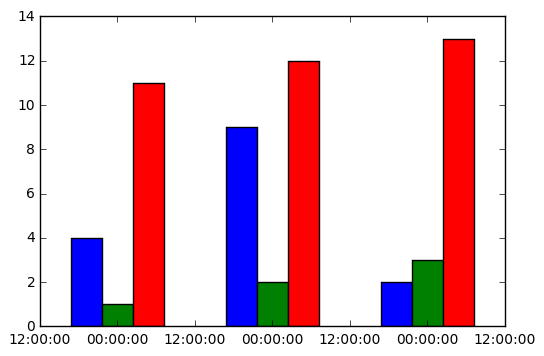

In [254]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import datetime

x = [datetime.datetime(2011, 1, 4, 0, 0),
     datetime.datetime(2011, 1, 5, 0, 0),
     datetime.datetime(2011, 1, 6, 0, 0)]
x = date2num(x)

y = [4, 9, 2]
z=[1,2,3]
k=[11,12,13]

ax = plt.subplot(111)
ax.bar(x-0.2, y,width=0.2,color='b',align='center')
ax.bar(x, z,width=0.2,color='g',align='center')
ax.bar(x+0.2, k,width=0.2,color='r',align='center')
ax.xaxis_date()

plt.show()

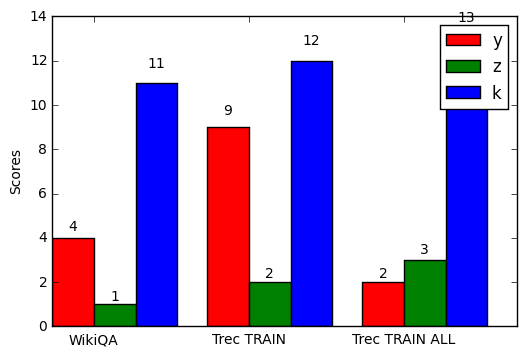

In [256]:
import numpy as np
import matplotlib.pyplot as plt

N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = [4, 9, 2]
rects1 = ax.bar(ind, yvals, width, color='r')
zvals = [1,2,3]
rects2 = ax.bar(ind+width, zvals, width, color='g')
kvals = [11,12,13]
rects3 = ax.bar(ind+width*2, kvals, width, color='b')

ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('WikiQA', 'Trec TRAIN', 'Trec TRAIN ALL') )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('y', 'z', 'k') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()